# Quantum Support Vector Machine

In this notebook, we introduce the Quantum Support Vector Machine in the qiskit framework.

Let us start with warning:

* If you will search for some examples over the internet, you may come over many examples (sadly, even on qiskit webpage) which are based on deprecated libraries

* Previously, the ML utilities have been under "aqua"

        * from qiskit.aqua.algorithms import QSVM
            vs
        * from qiskit_machine_learning.algorithms import QSVC

    * The first call is not valid anymore (you can always downgrade the version of the library you are running)
        
***

***
## Objective

* The QSVM -- the Quantum Support Vector Machine
    * The Quantum-enhanced Support Vector Machine
    * The quantum part is the kernel -- the quantum kernel is then used as a part of the kernel trick
    
* The quantum kernel can be used with other methods as well:
    * Kernel PCA with Quantum Kernel
    * Kernel Ridge Regression with Quantum Kernel
    * ... and few others
    
* The quantum know-how is in building the kernel, the classical algorithm around is using it
    * Objective the next block


***

***
## Setting Qiskit Workbench

* Let us first setup the usual qiskit stuff...

***

In [1]:
# Import numpy
import numpy as np

In [2]:
# Import basic object from the Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer,BasicAer
from qiskit import execute

# We will need these two
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel

# Load account from the disk
from qiskit import IBMQ
IBMQ.load_account() 

# We will need this for plots
from qiskit.visualization import plot_histogram,plot_bloch_multivector

In [3]:
# Check the version of the qiskit you use

# Compared to previous class, I have installed the up-to-date version
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

## Reminder: Simulators

We will define ideal and noise simulator.

In [4]:
# Ideal simulator
simulator = Aer.get_backend('qasm_simulator')

In [5]:
# Real-like simulator
from qiskit.providers.aer.noise import NoiseModel

# Choose a particuler quantum computer 
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_belem')

# We derive the noise model from the chosen quantum computer
noise_model = NoiseModel.from_backend(backend)

# Further, we assume the specific qauntum computer:
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

ibmqfactory.load_account:WARNING:2022-03-07 20:28:08,023: Credentials are already in use. The existing account in the session will be replaced.


In [6]:
# Run the simulator with noise -- wrap it up
def executeWithNoise(crt):
    return execute(crt, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model, shots=1024)

def executeWithoutNoise(crt):
    return execute(crt, Aer.get_backend('qasm_simulator'), shots=1024)

# We may not need exactly this, but let us see...

## Quantum Kernel

* Let us get the quantum kernel

* We do not split data into training/testing for now


In [7]:
# Data set
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=30, noise=0.3, random_state=0)

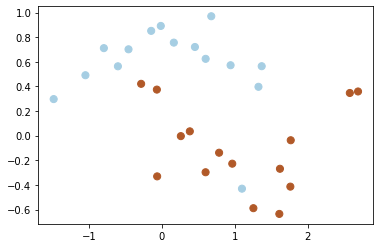

In [8]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.Paired)

***
Kernel generation step by step.

***

***
### The second order Pauli Z-evolution circuit
***

In [9]:
# Define Feature map, Pauli-Z evolution circuit 
from qiskit.circuit.library import ZZFeatureMap


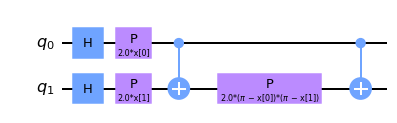

In [10]:
# 2-qubits, 1 repetition
prep = ZZFeatureMap(2, reps=1)
prep.decompose().draw(output='mpl')

***
P-gate: Single qubit rotationa round Z-axis. 

* .p(phase) -- gate with phase

The matrix representation:

$$
P=
\begin{pmatrix}
1 & 0\\
0 & e^{i\lambda}
\end{pmatrix}
$$

***

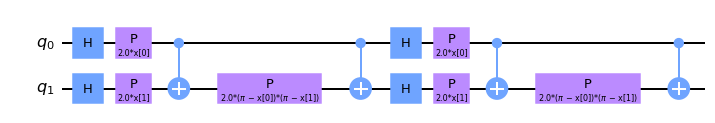

In [11]:
# 2-qubits, 2 repetition
prep = ZZFeatureMap(2, reps=2)
prep.decompose().draw(output='mpl')

***
We can change the entaglement:

* Default: entanglement='full'

* Option: entanglement='linear'

***

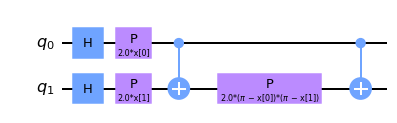

In [12]:
# 2-qubits, 1 repetition, linear entaglement
prep = ZZFeatureMap(2, reps=1,entanglement='linear')
prep.decompose().draw(output='mpl')

***
What entaglement mean?

* "full" -- each qubit is entangled with all the others.
* "linear" -- the i-th qubit is entangled with qubit i+1
* "circular" -- linear entanglement but with an additional entanglement of the first and last qubit.

***

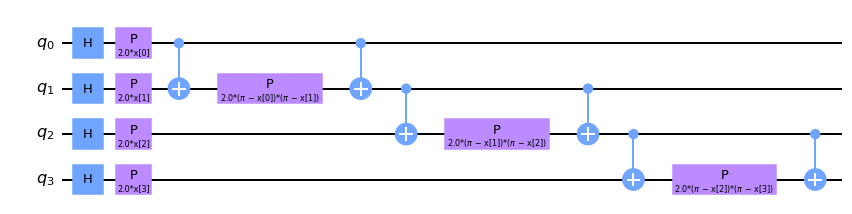

In [13]:
# 4-qubits, 1 repetition, linear entaglement
prep = ZZFeatureMap(4, reps=1,entanglement='linear')
prep.decompose().draw(output='mpl')

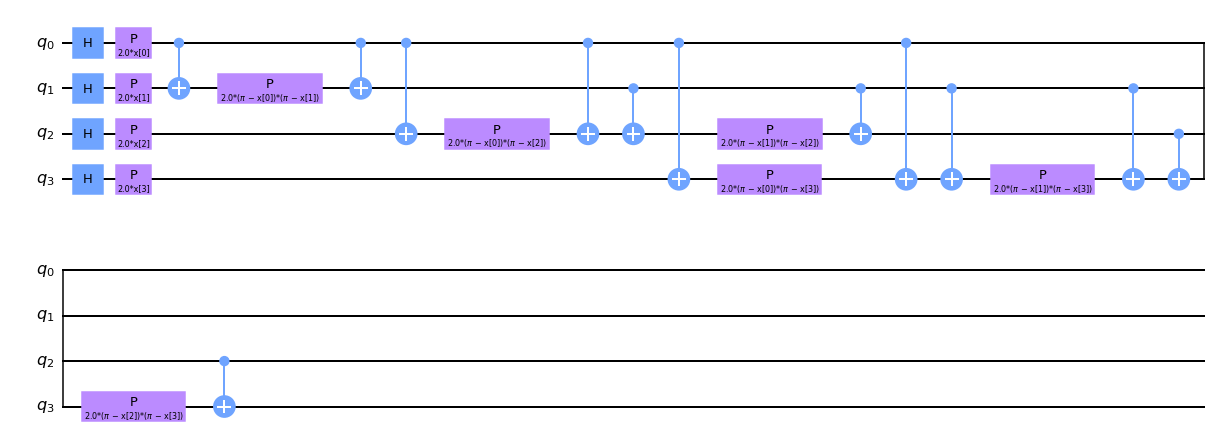

In [14]:
# 4-qubits, 1 repetition, linear entaglement
prep = ZZFeatureMap(4, reps=1,entanglement='full')
prep.decompose().draw(output='mpl')

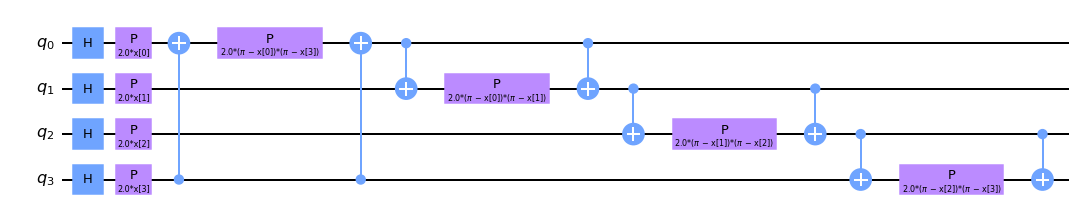

In [15]:
# 4-qubits, 1 repetition, linear entaglement
prep = ZZFeatureMap(4, reps=1,entanglement='circular')
prep.decompose().draw(output='mpl')

## Other feature maps

* We have started with ZZFeatureMap (hard to simulate classically)

* There are other feature maps available to us
    * We can use predefined feature maps
    * We can create our own feature maps from templates
    

***
### The Pauli Expansion circuit

***

In [16]:
# Pauli feature map
from qiskit.circuit.library import PauliFeatureMap

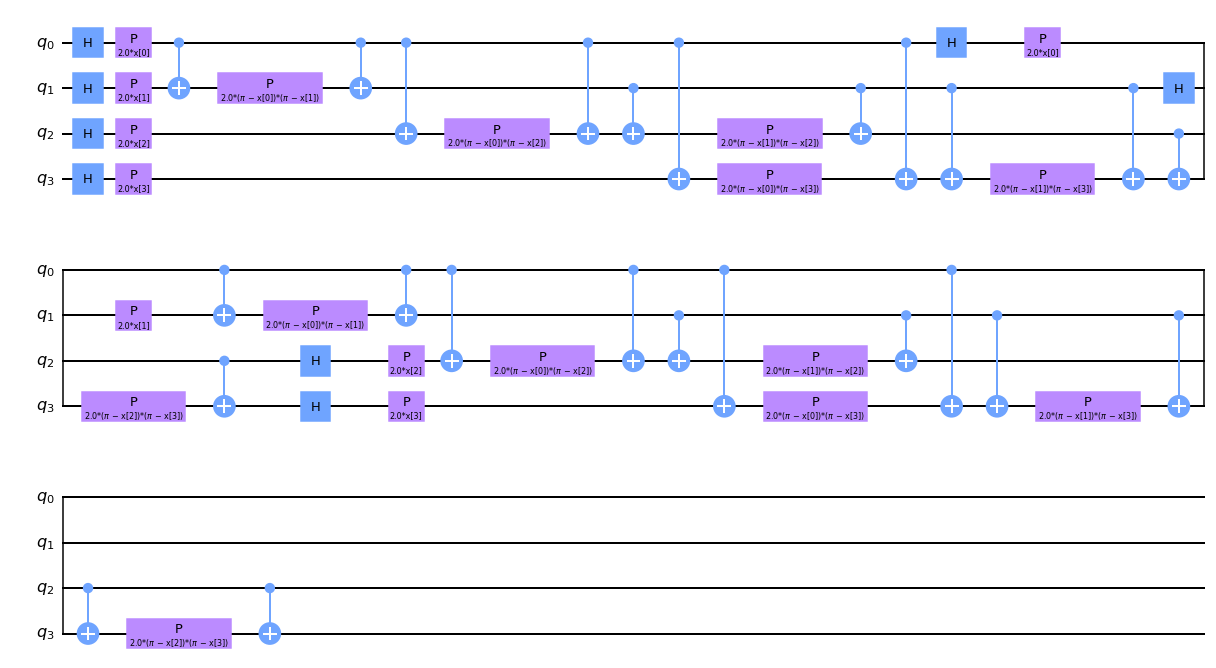

In [27]:
prep = PauliFeatureMap(feature_dimension=4, reps=2, entanglement='full', alpha=2.0, 
                       paulis=None, data_map_func=None, parameter_prefix='x',
                       insert_barriers=False, name='PauliFeatureMap')

prep.decompose().draw(output='mpl')

***
The option to choose our own Pauli matrices give us full flexibility and we can define very different feature maps. 

$$ paulis= ['Z', 'YY', 'ZXZ']$$

***

***
### The first order Pauli Z-evolution circuit
***

In [29]:
# Pauli feature map
from qiskit.circuit.library import ZFeatureMap

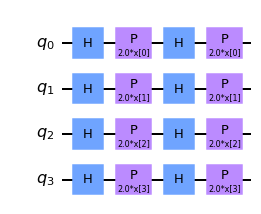

In [30]:
prep = ZFeatureMap(feature_dimension=4, reps=2, data_map_func=None, insert_barriers=False, name='ZFeatureMap')

prep.decompose().draw(output='mpl')

***
Only single-qubit gates, this is rather trivial feature expansion. 
***

***
To do: Try to explore and visualise the other combinations (more reps...)
***

***
Back to our dataset: 

***

In [31]:
X, y = make_moons(n_samples=30, noise=0.3, random_state=0)

# dimension of problem (number of qubits)
nQubits = X.shape[1]
# number of repetitions
nReps = 1

featureMap = ZZFeatureMap(feature_dimension=nQubits, reps=nReps, entanglement="linear")

In [32]:
# define backend (simulator)
backendSim = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=1024
)

In [33]:
# define Quantum kernel using the above feature map
kernelQuantum = QuantumKernel(feature_map=featureMap, quantum_instance=backendSim)

***
## SVM with Quantum Kernel Trick

* We use the SVM we have covered so far

* We use the kernel trick 

    * In the Classical SVM, we have used "rbf" kernel, which is defined in the sklearn library
    * The sklearn implementation allows us to use a user-defined kernel 
        * kernel = callable 
        * we can provide our own kernel 
        * QuantumKernel returns the suitable format
        
***

In [34]:
# Import SVC from sklearn
from sklearn.svm import SVC

In [35]:
# Initialise the SCV with our quantum kernel
svcQuantum = SVC(kernel=kernelQuantum.evaluate)

In [36]:
# We fit the SVM
svcQuantum.fit(X, y)

SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7f9a4d36bbb0>>)

In [37]:
# Accuracy of the fit (in-sample!)
svcQuantum.score(X, y)

0.7

In [38]:
# Prediction
yPredict = svcQuantum.predict(X)

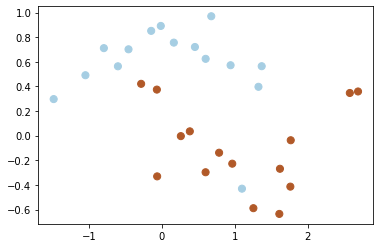

In [39]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.Paired)

In [40]:
XWrong = []

for Xi, yi,yPredicti in zip(X,y,yPredict):
    if yi!=yPredicti:
        XWrong.append([Xi[0],Xi[1]])

XWrong=np.array(XWrong)

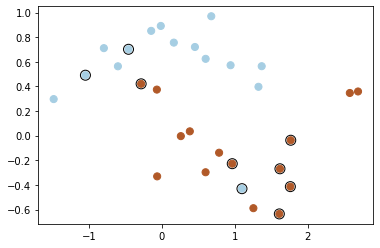

In [41]:
# Plotting the worngly identified points
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.Paired)

plt.scatter(
    XWrong[:, 0],
    XWrong[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

***
Compare with SVC with rbf kernel:
***

In [42]:
# Initialise the SCV with our quantum kernel
svcRBF = SVC(kernel="rbf")
# We fit the SVM
svcRBF.fit(X, y)
# Accuracy of the fit (in-sample!)
svcRBF.score(X, y)


0.9

***
## First Observation:

* __"Quantum" does not mean superiority!__

* Using quantum kernel does not achieve the superior performance!

***

***
## Quantum SVM with Realistic Simulator

***

In [43]:
# define backend (simulator with specific noise)
backendSimWithNoise = QuantumInstance(
    Aer.get_backend("qasm_simulator"), 
    coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model,
                shots=1024
)

In [44]:
# define Quantum kernel using the above feature map with noise
kernelQuantumWNoise = QuantumKernel(feature_map=featureMap, quantum_instance=backendSimWithNoise)

In [45]:
# Initialise the SCV with our quantum kernel
svcQuantumWNoise = SVC(kernel=kernelQuantumWNoise.evaluate)

In [46]:
# We fit the SVM
svcQuantumWNoise.fit(X, y)

SVC(kernel=<bound method QuantumKernel.evaluate of <qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7f9a2dc3deb0>>)

In [47]:
# Accuracy of the fit (in-sample!)
svcQuantumWNoise.score(X, y)

0.7666666666666667

***
... I would not compare performance, the sample is small and we should not generalise!

* The purpose is to show realistic estimation using Quantum Computer

***

***
## Plot of the kernel

***

In [48]:
matrixQuantum = kernelQuantum.evaluate(x_vec=X)
matrixQuantum

array([[1.01225272e+00, 9.26285737e-02, 8.17172198e-02, 5.64502215e-02,
        4.01937867e-01, 1.31075003e-01, 4.39312171e-01, 5.02290377e-01,
        2.30022688e-02, 2.91668940e-01, 4.00839772e-01, 7.20616650e-04,
        1.03086538e-01, 8.53059703e-02, 7.54334381e-02, 3.00070324e-01,
        6.16299178e-02, 3.48630795e-02, 3.23917647e-02, 5.31688551e-01,
        1.54305974e-01, 2.65536753e-01, 7.04399189e-02, 1.57974080e-01,
        5.25436097e-01, 7.92824980e-01, 2.25230476e-01, 4.62792546e-01,
        2.31264781e-02, 3.05706875e-02],
       [9.26285737e-02, 1.01018905e+00, 3.05739074e-02, 5.69599139e-01,
        2.40032356e-01, 3.86464385e-01, 3.71185547e-01, 7.51736566e-01,
        4.57598942e-01, 8.39999083e-02, 1.67492591e-01, 1.30035101e-02,
        2.86716762e-01, 1.09788901e-01, 3.52183662e-01, 2.33160801e-01,
        1.05787694e-01, 8.79380962e-01, 5.93678672e-02, 3.19321245e-02,
        1.03189983e-01, 1.99995370e-01, 3.50846818e-01, 3.35493996e-01,
        2.32178142e-01,

In [49]:
X

array([[ 1.32528202,  0.39666854],
       [ 2.57737504,  0.34644503],
       [-0.79345979,  0.71066888],
       [-0.14512164,  0.85096173],
       [ 1.76235838, -0.41418388],
       [ 1.61125658, -0.63580152],
       [ 1.76769902, -0.03743959],
       [-1.04637165,  0.49069383],
       [-0.06324376, -0.33085195],
       [ 0.96616032, -0.22779622],
       [ 0.67846471,  0.96969825],
       [-0.28278155,  0.42073671],
       [ 0.16528853,  0.75549044],
       [-1.48162068,  0.29684285],
       [ 1.25576532, -0.58920734],
       [ 0.60060401, -0.29737508],
       [ 0.45444028,  0.72002627],
       [ 2.68993146,  0.35865942],
       [ 0.60133558,  0.62377328],
       [ 0.94322656,  0.57185027],
       [ 0.26139225, -0.00392717],
       [ 0.38457097,  0.03491966],
       [-0.45583877,  0.70125267],
       [-0.01323372,  0.89101989],
       [ 1.61978636, -0.26919504],
       [ 1.36962025,  0.56396209],
       [ 1.09916032, -0.43074852],
       [ 0.78573756, -0.13874652],
       [-0.06721163,

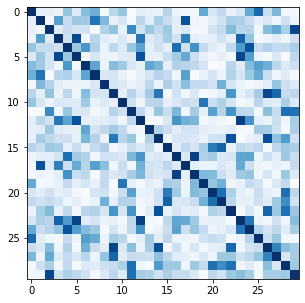

In [50]:
# The kernel is calculated for the X-points k(x_i,x_j)
fig, axs = plt.subplots(figsize=(10, 5))
axs.imshow(
    np.asmatrix(matrixQuantum), interpolation="nearest", origin="upper", cmap="Blues"
)

***
### Remark

If we need to evaluate the kernel on new data set (e.g., test data, we need to run below) 

        * kernelQuantum.evaluate(x_vec=Xtest, y_vec=Xtrain)
        
* This reveals the requirement of the kernel
    * x_vec
    * y_vec (if none, it is the same as x_vec)
    
***

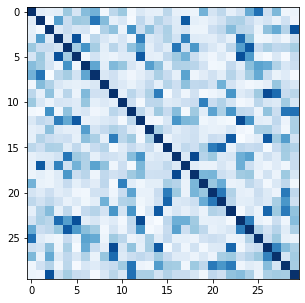

In [51]:
matrixQuantumWNoise = kernelQuantumWNoise.evaluate(x_vec=X)
fig, axs = plt.subplots(figsize=(10, 5))
axs.imshow(
    np.asmatrix(matrixQuantumWNoise), interpolation="nearest", origin="upper", cmap="Blues"
)

***
We can compare the kernels, but that is not objective for now. 

* Let us compare with RBF

***

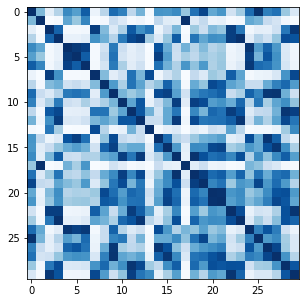

In [52]:
from sklearn.gaussian_process.kernels import RBF
kernel = 1.0 * RBF(1.0)

matrixRBF = kernel(X)
fig, axs = plt.subplots(figsize=(10, 5))
axs.imshow(
    np.asmatrix(matrixRBF), interpolation="nearest", origin="upper", cmap="Blues"
)

***
At first sight, the quantum kernel is more noisy. 

* In general, quantum kernel allows to explore more complex pattern (at risk of the overfit!)

***

### More deep kernel

Let us try another deep kernel.

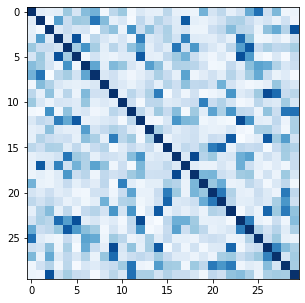

In [53]:
# dimension of problem (number of qubits)
nQubits = X.shape[1]
# number of repetitions
nReps = 3

featureMap3 = ZZFeatureMap(feature_dimension=nQubits, reps=nReps, entanglement="linear")

# define Quantum kernel using the above feature map
kernelQuantum3 = QuantumKernel(feature_map=featureMap3, quantum_instance=backendSim)

matrixQuantum3 = kernelQuantum3.evaluate(x_vec=X)
fig, axs = plt.subplots(figsize=(10, 5))
axs.imshow(
    np.asmatrix(matrixQuantumWNoise), interpolation="nearest", origin="upper", cmap="Blues"
)

***
Plot the difference between kernels
***

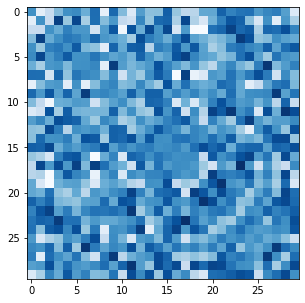

In [54]:
fig, axs = plt.subplots(figsize=(10, 5))
axs.imshow(
    np.asmatrix(matrixQuantum-matrixQuantum3), interpolation="nearest", origin="upper", cmap="Blues"
)

***
Kernels are not the same, there are differences but we cannot interpret them visually. 

***

In [55]:
# Initialise the SCV with our quantum kernel
svcQuantum3 = SVC(kernel=kernelQuantum3.evaluate)
# We fit the SVM
svcQuantum3.fit(X, y)
# Accuracy of the fit (in-sample!)
svcQuantum3.score(X, y)

0.8333333333333334

***
Accuracy is improved!

### Warning!

It would be more accurate to say that accuracy changed. This means that parameters of the quantum kernel are hyperparameters of the model and they should be treated accordingly!

* Cross-validation and search for the right hyper-parameter!

* In the Classical SVM section, we have discussed parameter C, which have not discussed yet

***

***
# Qiskit SVMC

There is a built-in function within the qiskit for QSV. This is nothing but rather simpler wrapper. 

It takes all the parameters the regular SVC takes -- they are passed to the classical SVC constructor. 

Recommendation:

* It may be worth sticking to the qiskit SVC function
* We consider quantum kernel as extension (of our existing battery of the ML methods)
* Unless there is strong prior, worth to keep options of available Ml methods open. 


***

In [56]:
# Load the QSVC from qiskit
from qiskit_machine_learning.algorithms import QSVC

In [57]:
qsvc = QSVC(quantum_kernel=kernelQuantum3)
qsvc.fit(X, y)
qsvc.score(X, y)

0.8333333333333334

***
We get the same result as we have above with kernel3.
***

***
# Another Example

* The quantum kernel can capture very complex patterns

* We try fully random data-set, in-sample 

***

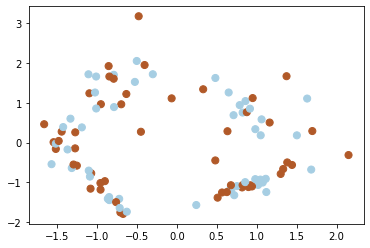

In [58]:
# Data
from sklearn.datasets import make_classification
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_classes=2, n_clusters_per_class=2
)
# Make y fully random
import random
random.shuffle(y)

import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.Paired)

In [59]:
# Fit SVC with RBF
svcClassic = SVC(kernel="linear", C=0.025)
svcClassic.fit(X,y)
svcClassic.score(X,y)


0.54

In [60]:
# Fit SVC with Quantum Kernel
nQubits = X.shape[1]
# number of repetitions
nReps = 1

featureMap = ZZFeatureMap(feature_dimension=nQubits, reps=nReps, entanglement="linear")

# define Quantum kernel using the above feature map
kernelQuantum = QuantumKernel(feature_map=featureMap, quantum_instance=backendSim)

# kernel
svcQuantum = SVC(kernel=kernelQuantum.evaluate)

# We fit the SVM
svcQuantum.fit(X, y)

# Accuracy of the fit (in-sample!)
svcQuantum.score(X, y)

0.64

***
* Better fit here means that the quantum kernel can overfit data more!

* The kernel itself is "non-linear" (one would say very non-linear)

    * Would you use it to fit the trend, or, to fit what remains once you fit the trend?

***

***
# Next Lesson:

* We will focus on the workflow with QSVM

* We explore how we can explore the quantum kernels

***